In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')
from utils import *
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

Load file containing candidate -> corpus mapping :

In [19]:
f = open("../communities/v1/candidate_to_tweets", "rb")
candidate_to_tweets = pickle.load(f)
f.close()

In [3]:
candidates_mapping = {
    0 : "Arthaud",
    1 : "Asselineau",
    2 : "Cheminade",
    3 : "Dupont-Aignan",
    4 : "Fillon",
    5 : "Hamon",
    6 : "Lassalle",
    7 : "Le Pen",
    8 : "Macron",
    9 : "Mélenchon",
    10 : "Poutou"
}

In [38]:
for cand in candidate_to_tweets.keys():
    print("{} ({}) - nombre de tweets : {}".format(candidates_mapping[cand], cand, \
                                              len(candidate_to_tweets[cand][0])))

Macron (8) - nombre de tweets : 4475
Mélenchon (9) - nombre de tweets : 5198
Fillon (4) - nombre de tweets : 2979
Hamon (5) - nombre de tweets : 2634
Le Pen (7) - nombre de tweets : 3060


In [39]:
for candidate, data in candidate_to_tweets.items():
    print(">>> Communauté {}".format(candidates_mapping[candidate]))
    tweets = data[0]
    sentiments = data[1]
    ind = np.random.choice(range(0,len(tweets)), 5, replace=False)
    sample_tweets = tweets[ind]
    sample_sent = sentiments[ind]
    for i in range(5):
        print("\t{} \n\t-> {}".format(sample_tweets[i], int(sample_sent[i])))
    print("-------------------------------")

>>> Communauté Macron
	SCANDALE:#Macron reconnaît que les messages d Mohammed Saou ont une part de gravité, mais voit en lui "un type bien" https://t.co/BlI8tPw3AR 
	-> 1
	Hollande a bien nommé #Taubira !!!! on voit le résultat ?????
#jevoteFillon #FillonPresident https://t.co/Cn0pI139be 
	-> -1
	Macron va gagner ces élections! https://t.co/kF5eD8nuMX 
	-> 1
	@raphyane @AssoUPF #Sarkozy et #Fillon ont su sauver notre économie dans l'une des pires crises financières.
Hollan… https://t.co/HudCO6XHew 
	-> -1
	Selon Le Canard enchaîné, Macron aurait accordé 900 millions d’euros de baisse d’impôts aux cadres du CAC 40 https://t.co/RVJ9yYPqgd via @ 
	-> 1
-------------------------------
>>> Communauté Mélenchon
	@Manifou @Letankytank @the_boss2016_ @TwittAir01 @JLMelenchon @jccambadelis N'importe quoi regarde le meeting de Li… https://t.co/uoVZtrwog1 
	-> 1
	MARISA MATIAS SOUTIENT JLM2017 https://t.co/slAGo0aQbF via @YouTube 
	-> 1
	#Presidentielle2017 Ce que #MarineLePen nous (vous) prépare

In [37]:
corpus = []
labels = []
for cand, data in candidate_to_tweets.items():
    tweets = data[0]
    sentiments = data[1]
    corpus = np.append(corpus, tweets)
    labels = np.append(labels, sentiments)

In [40]:
len(corpus)

18346

In [42]:
corpus, ind, unique_counts = np.unique(corpus, return_index=True, return_counts=True)

In [44]:
len(corpus)

18246

In [43]:
labels = labels[ind]

In [55]:
# ratio positif sur négatif
np.count_nonzero(labels == 1) / np.count_nonzero(labels == -1)

0.8454536259735006

In [45]:
[vectorizer, X] = build_vectorizer(corpus,\
                                     stopwords=french_stopwords(),\
                                     b_stemming=True,\
                                     b_rmaccent=True,\
                                     b_lowercase=True,
                                    b_rmnumbers=True)

Removing numbers
Removing stopwords
Stemming
Removing uppercases
Removing accents


In [46]:
words_freq = get_words_freq(vectorizer,X)

In [47]:
pd.DataFrame(words_freq).head(10)

,0,1
0,macron,5835
1,melenchon,4370
2,fillon,3755
3,hamon,1875
4,vot,1665
5,franc,1249
6,vi,1214
7,plus,991
8,jlm2017,974
9,fait,812


In [48]:
# pour vérifier à l'oeil
tweets_test = np.array(["Emmanuel #Macron l'escroquerie en marche", 
               "#EminemVsMelenchon #JLM2017 Des qu'un mec perce en France Eminem se sent obligé de le clasher...",
              "Au 2nd tour : #Fillon et #Mélenchon. L'électorat de droite fermera les yeux sur les affaires, celui de gauche ouvrira les siens sur #Macron.",
              "Couverts par le #PS.",
            "Ah bah voilà qui devrait rassurer @JLMelenchon... https://t.co/PVjlmyvWfA",
            "Ne vous trompez pas de bulletin de vote #JLM2017 pour la paix les autres c'est la guerre https://t.co/zz67XLndCd"])

X_test2 = vectorize_docs(vectorizer, tweets_test)

## Première version

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3,random_state=0,stratify=labels)

In [58]:
n_C = 100
interval = np.logspace(-5, 5, n_C)

mean_scores = []
for C in interval:
    clf = LinearSVC(C=C)
    scores = cross_val_score(clf, X_train, y_train, cv=4,scoring='f1')
    mean_scores.append(np.mean(scores)) 

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

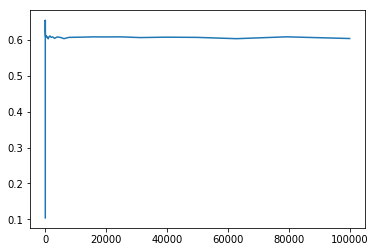

In [59]:
plt.plot(interval, mean_scores)
plt.show()

In [60]:
C_opt = interval[np.argmax(mean_scores)]
clf = LinearSVC(C=C_opt)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
f1_score(y_test,y_pred,pos_label=1)

0.65587044534412964

In [67]:
ind_neg = np.argsort(clf.coef_).flatten()[0:10]
ind_pos = np.argsort(clf.coef_).flatten()[clf.coef_.shape[1]-10:]

In [70]:
np.sort(clf.coef_)

array([[-0.88505988, -0.68836106, -0.64711426, ...,  0.83069181,
         0.83871227,  0.99335108]])

In [68]:
np.array(vectorizer.get_feature_names())[ind_neg]

array(['dupontaignan', 'clairock', 'feedly', 'fillonpresident', 'scolair',
       'jevotefillondeslepremiertour', 'erichacquemand', 'jacqu',
       'stopmelenchon', 'benoît'],
      dtype='<U39')

In [69]:
np.array(vectorizer.get_feature_names())[ind_pos]

array(['jlmtoulous', 'franceinsoumis', 'bisounour', 'corrompu',
       'marineàpar', 'manson_fx', 'ptit', 'emmanuelholland', 'hamon2017',
       'stopmacron'],
      dtype='<U39')

## Macron against all

In [149]:
labels_2 = split_binary(labels, 8)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_2, test_size=0.3,random_state=0,stratify=labels_2)

In [135]:
n_C = 200
interval = np.logspace(-5, 5, n_alphas)

mean_scores = []
for C in interval:
    clf = LinearSVC(C=C)
    scores = cross_val_score(clf, X_train, y_train, cv=4,scoring='f1')
    mean_scores.append(np.mean(scores)) 

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/pyt

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/pyt

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

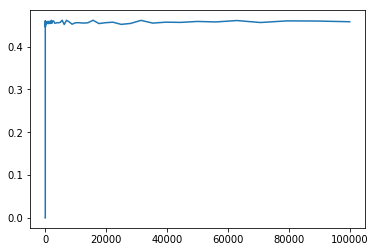

In [136]:
plt.plot(interval, mean_scores)
plt.show()

In [137]:
C_opt = interval[np.argmax(mean_scores)]
clf = LinearSVC(C=C_opt)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
f1_score(y_test,y_pred,pos_label=1)

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.47247706422018354

In [138]:
clf.predict(X_test2)

array([-1., -1., -1., -1., -1., -1.])

## Le Pen against all

In [139]:
labels_3 = split_binary(labels, 7)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_3, test_size=0.3,random_state=0,stratify=labels_3)

In [141]:
n_C = 200
interval = np.logspace(-5, 5, n_alphas)

mean_scores = []
for C in interval:
    clf = LinearSVC(C=C)
    scores = cross_val_score(clf, X_train, y_train, cv=4,scoring='f1')
    mean_scores.append(np.mean(scores)) 

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/pyt

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lauranguyen/anaconda3/lib/pyt

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

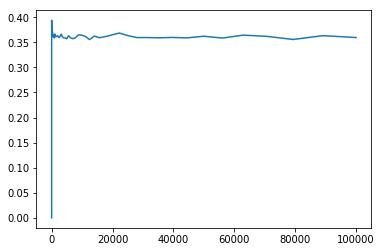

In [142]:
plt.plot(interval, mean_scores)
plt.show()

In [143]:
C_opt = interval[np.argmax(mean_scores)]
clf = LinearSVC(C=C_opt)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
f1_score(y_test,y_pred,pos_label=1)

0.38388625592417064